# Explanations using Naive Bayes Model

A notebook to illustrate the principle of using an additive model to generate explanations for binary outcomes.

As a reminder, our goal is to *explain* an observed outcome. We do so by identifying a set of causal factors and the task of the model is to produce a rank-ordering of those factors by their causal contribution to the event.

This notebook demonstrates a simple, interpretable approach to propose plausible causal factors for a binary outcome by combining per-feature logistic regressions in a naive Bayes-style model. Each feature gets its own logistic regression trained to predict the log of relative odds, and the contributions are aggregated to form an explanation for why the outcome may have occurred.


## Sample Data Generation

We generate random binomial data to illustrate the relationship between a single factor `X` and the probability of observing an anomaly (`y = 1`). The probability of an anomaly is modeled as a logistic function of `X`, allowing us to visualize and explain how changes in `X` affect the likelihood of an event.

In [28]:
# Generate data
import numpy as np

# Basic log-odds relationship
def logodds(x, ix=0, base_odds=1.0):
    if ix == 0:
        return 0.5 * x - 2.0 - np.log(base_odds)
    elif ix == 1:
        return 0.25 * x - 2.5 - np.log(base_odds)
    elif ix == 2:
        return -0.4 * x - 1.5 - np.log(base_odds)
    else:
        return 0.0

# Inverse function
def inv_logodds(y, ix=0, base_odds=1.0):
    if ix == 0:
        return (y + 2.0 + np.log(base_odds)) / 0.5
    elif ix == 1:
        return (y + 2.5 + np.log(base_odds)) / 0.25
    elif ix == 2:
        return (y + 1.5 + np.log(base_odds)) / -0.4
    else:
        return 0.0

# Generate 300 x values uniformly distributed between -5 and 5
x_values = np.random.uniform(-5, 5, 300)

# Calculate the probabilities for y using the logodds function
probabilities = 1 / (1 + np.exp(-logodds(x_values)))

# Generate y values as binomial (1 or -1) based on the calculated probabilities
y_values = np.random.binomial(1, probabilities) * 2 - 1

# Calculate base_odds as ratio of y=1 to y=-1
base_odds = np.mean(y_values == 1) / np.mean(y_values == -1)
print(f"Base Odds: {base_odds*100:.0f}:100")
# Combine x and y values into pairs
xy_pairs = list(zip(x_values, y_values))

Base Odds: 22:100


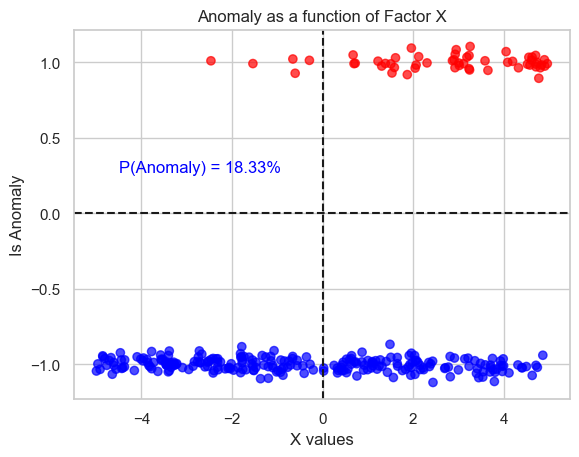

In [29]:
# Plot the data
import matplotlib.pyplot as plt

# Extract x and y values from xy_pairs
x_vals, y_vals = zip(*xy_pairs)

# Add small random noise to x and y values for dithering
x_vals_dithered = np.array(x_vals) + np.random.normal(0, 0.04, len(x_vals))
y_vals_dithered = np.array(y_vals) + np.random.normal(0, 0.04, len(y_vals))

# Create a scatter plot with dithered values
plt.scatter(x_vals_dithered, y_vals_dithered, c=y_vals, cmap='bwr', alpha=0.7)
plt.xlabel('X values')
plt.ylabel('Is Anomaly')
plt.title('Anomaly as a function of Factor X')
# plt.colorbar(label='Y values')
prob = 100* base_odds / (1 + base_odds)
plt.text(-4.5, 0.25, f"P(Anomaly) = {prob:.2f}%", color='blue', va='bottom', ha='left')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

plt.show()

In [30]:
# Define the bins
bins = np.linspace(-5, 5, 11)

# Initialize a list to store the odds
odds = []

# Loop through each bin range
for i in range(len(bins) - 1):
    # Get the x and y values that fall into the current bin
    bin_x_vals = [x for x in x_vals if bins[i] <= x < bins[i + 1]]
    bin_y_vals = [y for x, y in xy_pairs if bins[i] <= x < bins[i + 1]]
    
    # Calculate the count of y=1 and y=-1
    count_y1 = bin_y_vals.count(1)
    count_y_minus1 = bin_y_vals.count(-1)
    
    # Calculate the odds
    if count_y_minus1 == 0:
        odds.append(5)
    else:
        odds.append(count_y1 / count_y_minus1)


## Fit a Logistic Regression Model

### Measure the Odds as a function of X.
Odds is simply $o_1 = \frac{n_1}{n_0}$. Note relation to probability: $P(1) = \frac{o_1}{1+o_1}$

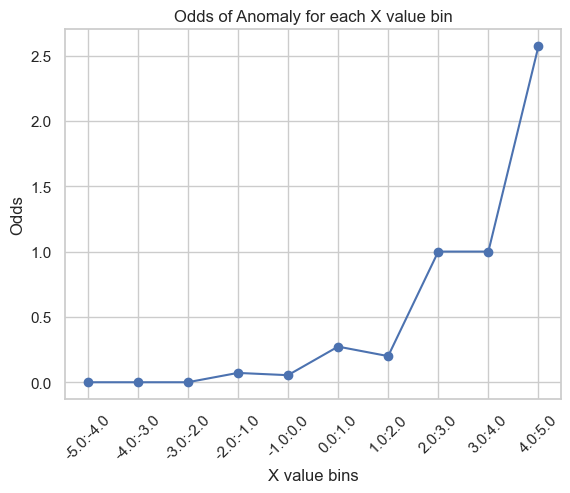

In [12]:
# Plot the binned result
# Calculate the center of each bin
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create x-y pairs with x being the center of the bin and y being the odds
xy_odds_pairs = list(zip(bin_centers, odds))

# Extract x and y values from xy_odds_pairs
x_vals_odds, y_vals_odds = zip(*xy_odds_pairs)

# Plot the result with lines-points and slanted x-labels
plt.plot(x_vals_odds, y_vals_odds, marker='o', linestyle='-')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.xlabel('X value bins')
plt.ylabel('Odds')
plt.title('Odds of Anomaly for each X value bin')
plt.show()

### Fit linear model to log(odds).
The problem with odds is that it isn't symmetrical. Solve by taking log. We then fit a line to the log(odds)


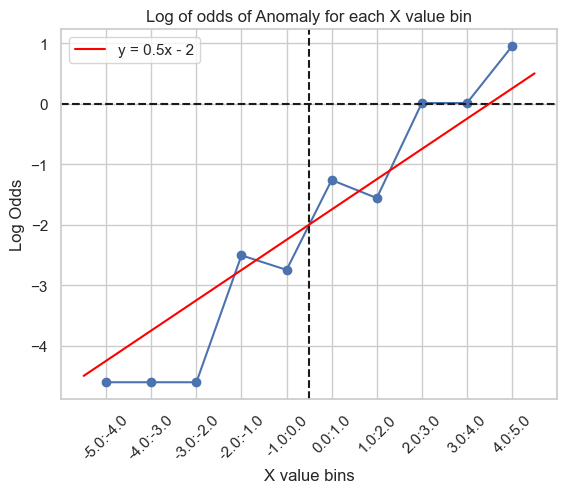

In [13]:
# Fit a line
# Extract x and y values from xy_odds_pairs
y_vals_logodds = np.log(np.array(y_vals_odds) + 0.01)

# Plot the result with lines-points and slanted x-labels
plt.plot(x_vals_odds, y_vals_logodds, marker='o', linestyle='-')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)
plt.xlabel('X value bins')
plt.ylabel('Log Odds')
plt.title('Log of odds of Anomaly for each X value bin')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Overlay the line y = 0.5x - 1
x_line = np.linspace(-5, 5, 100)
#y_line = 0.5 * x_line - 1
y_line = [logodds(x) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2')

plt.legend()
plt.show()

## Convert to Relative Odds
Since we are looking at multiple factors, it is useful to model odds relative to the base rate. We can easily do that by dividing odds as a function of a factor by the overall odds (in log space that means subtracting the base odds).

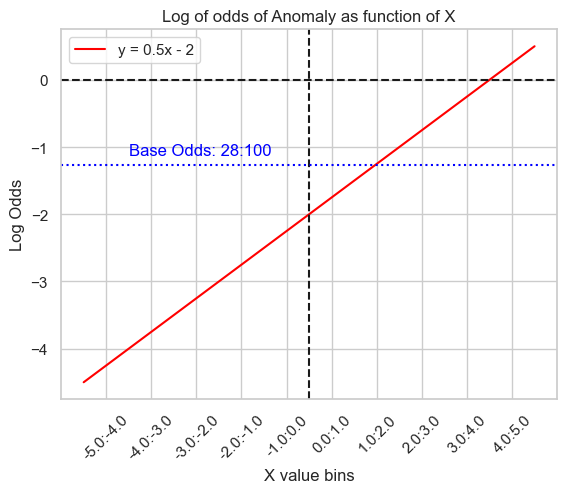

In [14]:
# Show the base odds
# Overlay the line y = 0.5x - 1
x_line = np.linspace(-5, 5, 100)
y_line = [logodds(x) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2')
plt.xticks(ticks=x_vals_odds, labels=[f'{bins[i]}:{bins[i+1]}' for i in range(len(bins) - 1)], rotation=45)

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Add a dotted horizontal line at y=-2 with label "Base Odds"
plt.axhline(y=np.log(base_odds), color='blue', linestyle=':')
plt.text(-4, np.log(base_odds)+0.1, f'Base Odds: {base_odds*100:.0f}:100', color='blue', va='bottom', ha='left')

plt.xlabel('X value bins')
plt.ylabel('Log Odds')
plt.title('Log of odds of Anomaly as function of X')
plt.legend()
plt.show()

### Relative Odds Model
This leaves us with a useful measure of how any times more/less likely a factor made the observation of an anomaly.

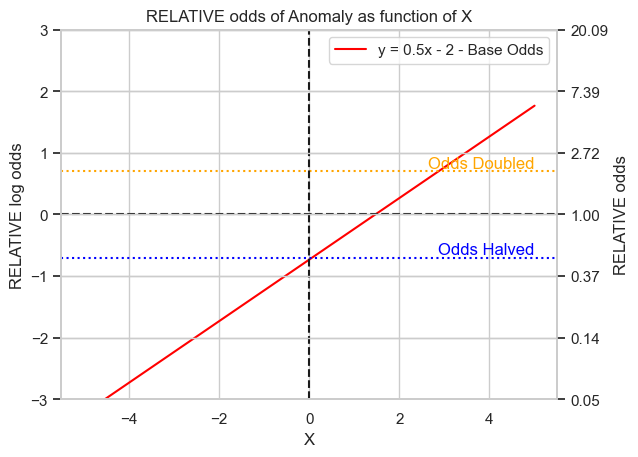

In [15]:
# Plot the relative odds
x_line = np.linspace(-5, 5, 100)
y_line = [logodds(x, base_odds=base_odds) for x in x_line]
plt.plot(x_line, y_line, color='red', linestyle='-', label='y = 0.5x - 2 - Base Odds')

# Add a dotted horizontal line at y=-0.7 with label "Odds halved"
plt.axhline(y=-0.7, color='blue', linestyle=':')
plt.text(5, -0.7, 'Odds Halved', color='blue', va='bottom', ha='right')

# Add a dotted horizontal line at y=0.7 with label "Odds Doubled"
plt.axhline(y=0.7, color='orange', linestyle=':')
plt.text(5, 0.7, 'Odds Doubled', color='orange', va='bottom', ha='right')

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

# Update y-tick labels to be exp(y)
yticks = ax.get_yticks()

# Fix the Y-limits to be -3 to 3
ax.set_ylim(-3, 3)



plt.legend()
plt.xlabel('X')
plt.ylabel('RELATIVE log odds')
plt.title('RELATIVE odds of Anomaly as function of X')

# Create a secondary Y-axis
ax2 = ax.twinx()
ax2.set_ylabel('RELATIVE odds')
ax2.set_ylim(-3, 3)
yticks = ax.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{np.exp(y):.2f}' for y in yticks])

plt.show()

## Assigning Explanations
We do this for a number of assumed independent factors.

In the graph below we have illustrated 3 hypothetical factors. For Ecolab, examples are *hours staffed*, *ratio of slow chicked orders*, *Drive-thru service time relative to average*, etc.

As above, the relative (log) odds of observing an anomaly is modeled as a linear relationship. For each of our analysis units (shifts), we observe actual values for these factors (black dots) which then map to relative odds of an anomalous KPI. 


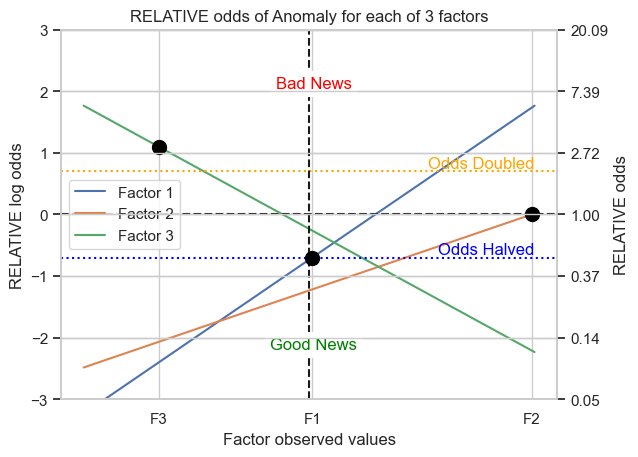

In [16]:
# Plot the lines for each log-odds function
x_line = np.linspace(-5, 5, 100)
for i in range(3):
    y_line = [logodds(x, i, base_odds=base_odds) for x in x_line]
    plt.plot(x_line, y_line, linestyle='-', label=f'Factor {i+1}')

# Add a dotted horizontal line at y=-0.7 with label "Odds halved"
plt.axhline(y=-0.7, color='blue', linestyle=':')
plt.text(5, -0.7, 'Odds Halved', color='blue', va='bottom', ha='right')

# Add a dotted horizontal line at y=0.7 with label "Odds Doubled"
plt.axhline(y=0.7, color='orange', linestyle=':')
plt.text(5, 0.7, 'Odds Doubled', color='orange', va='bottom', ha='right')

# Add a large dot for each of the 3 factors respectively
xtick_positions = []
for i, y in enumerate([-0.7, 0.0, 1.1]):
    x = inv_logodds(y, i, base_odds=base_odds)
    xtick_positions.append(x)
    plt.scatter(x, y, color='black', s=100, zorder=10)

# Setting x-ticks at specific positions with custom labels
xtick_labels = ['F1', 'F2', 'F3']
plt.xticks(xtick_positions, xtick_labels)

# Add axes
ax = plt.gca()
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

plt.xlabel('Factor observed values')
plt.ylabel('RELATIVE log odds')
plt.title('RELATIVE odds of Anomaly for each of 3 factors')
plt.legend()

# Fix the Y-limits to be -3 to 3
ax.set_ylim(-3, 3)

# Good/Bad news text
plt.text(0.1, 2, 'Bad News', color='red', va='bottom', ha='center', bbox=dict(facecolor='white', edgecolor='none'))
plt.text(0.1, -2, 'Good News', color='green', va='top', ha='center', bbox=dict(facecolor='white', edgecolor='none'))

# Create a secondary Y-axis
ax2 = ax.twinx()
ax2.set_ylabel('RELATIVE odds')
ax2.set_ylim(-3, 3)
yticks = ax.get_yticks()
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{np.exp(y):.2f}' for y in yticks])

plt.show()

We then model the odds of an anomaly as:

    Base Rate * Factor_1 * Factor_2 * Factor_3

| Factor        | Contribution | Rank | Note |
|---------------|--------------|------|------|
| Base Rate     | --           |      | 
| Factor 1      | 0.5          | 3    | This factor *reduced* the odds of an anomaly |
| Factor 2      | 1.0          | 2    | This factor did not contribute either way |
| Factor 3      | 3.0          | 1    | This factor increased the odds of an anomaly |

From this it is easy to extract that 
1. the observed value of *Factor 3* was the highest risk factor.
2. *Factor 1* reduced the risk of an anomaly, so is *good news*

# Explainer-Explainer: Formal implementation
We demonstrate below following the same approach using actual ML libraries to fit and evaluate models.

What you will find below:
- Problem framing and assumptions
- Reproducible environment setup
- A walk-through of the per-feature logistic models (normalized to relative odds)
- Aggregation into a naive Bayes explanatory model
- Visualizations to understand factor importance and per-sample explanations
- Guidance on extensions and limitations

## Assumptions and setup

Assumptions:
- Outcome `y` is binary.
- Features `X` can be numeric or one-hot encoded categorical.
- We treat features as conditionally independent given `y` (naive Bayes).

Key idea:
- For each feature `x_j`, fit a logistic regression predicting `y` from `x_j`.
- Convert the fitted coefficient to a log-relative-odds contribution.
- Sum contributions across features to score explanations per sample.
- Report top positive/negative contributors per outcome.

In [17]:
# Reproducible setup: imports, settings, and seeding
from __future__ import annotations
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss

# Plotting style
sns.set_theme(style="whitegrid", context="notebook")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Using numpy {np.__version__}, pandas {pd.__version__}")

Using numpy 2.2.6, pandas 2.3.1


## Method: Per-feature logistic models normalized to relative odds

We model each feature independently: fit `LogisticRegression(y ~ x_j)` and transform coefficients to represent changes in log-relative-odds relative to a baseline.

Implementation notes:
- Standardize numeric features to avoid scale-driven effects.
- For categorical features, use one-hot encoding first (not shown if already applied).
- Calibrate and aggregate contributions by summing per-feature log-relative-odds.
- Use ROC AUC and log loss of the aggregated score to sanity-check.

In [18]:
# Helper functions for per-feature logistic models and aggregation
from typing import Iterable

def _ensure_2d(x: np.ndarray) -> np.ndarray:
    if x.ndim == 1:
        return x.reshape(-1, 1)
    return x

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

@dataclass
class FeatureModel:
    name: str
    scaler: Optional[StandardScaler]
    coef_: float
    intercept_: float
    model: LogisticRegression

def fit_feature_model(x: np.ndarray, y: np.ndarray, name: str) -> FeatureModel:
    """Fit logistic regression for a single feature and return normalized params.

    The returned coefficients are the raw logistic regression params;
    normalization to log-relative-odds is handled when computing contributions.
    """
    X = _ensure_2d(np.asarray(x))
    scaler: Optional[StandardScaler] = None
    # Standardize numeric features for stability
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xs = scaler.fit_transform(X)
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(Xs, y)
    coef = float(lr.coef_.ravel()[0])
    intercept = float(lr.intercept_.ravel()[0])
    return FeatureModel(name=name, scaler=scaler, coef_=coef, intercept_=intercept, model=lr)

def contribution_log_relative_odds(fm: FeatureModel, x: np.ndarray) -> np.ndarray:
    """Compute per-sample log-relative-odds contribution from a feature model.

    We use the centered version so that contribution is relative to baseline (mean).
    """
    X = _ensure_2d(np.asarray(x))
    Xs = fm.scaler.transform(X) if fm.scaler is not None else X
    # Remove intercept: we account for baseline at aggregation stage
    return Xs.ravel() * fm.coef_

def aggregate_log_odds(feature_models: List[FeatureModel], X: pd.DataFrame) -> np.ndarray:
    """Sum per-feature log-relative-odds to obtain overall log-odds score.
    Assumes `X` columns align with feature_models by name.
    """
    parts: List[np.ndarray] = []
    for fm in feature_models:
        parts.append(contribution_log_relative_odds(fm, X[fm.name].values))
    return np.sum(np.column_stack(parts), axis=1)

def score_to_prob(log_odds: np.ndarray, base_rate: float) -> np.ndarray:
    """Convert aggregated log-relative-odds to probability using base rate.
    If base rate is p0, then baseline log-odds is log(p0/(1-p0)).
    """
    baseline = math.log(base_rate / (1 - base_rate))
    lo = baseline + log_odds
    return sigmoid(lo)

## Demo: Synthetic dataset to illustrate explanations

We will create a simple dataset with 3 informative numeric features and 2 noisy ones. The true data-generating process uses a logistic model, enabling us to check whether the explainer recovers plausible contributors.

In [19]:
# Generate synthetic binary classification data with known logistic structure
n = 2000
x1 = np.random.normal(0, 1, size=n)
x2 = np.random.normal(0, 1, size=n)
x3 = np.random.normal(0, 1, size=n)
x4 = np.random.normal(0, 1, size=n)  # noise
x5 = np.random.normal(0, 1, size=n)  # noise

beta = np.array([1.2, -0.8, 0.6])
logit = 0.2 + 1.2 * x1 + (-0.8) * x2 + 0.6 * x3
p = sigmoid(logit)
y = (np.random.rand(n) < p).astype(int)

df = pd.DataFrame({
    "x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "y": y, "p_true": p,
})
base_rate = df["y"].mean()
print(f"Base rate: {base_rate:.3f}")

Base rate: 0.538


### Train per-feature models and aggregate

We fit one logistic regression per feature and aggregate their contributions into an overall score, then convert to probabilities using the observed base rate.

In [20]:
# Train feature models
feature_names = [c for c in df.columns if c.startswith("x")]
y_arr = df["y"].values
feature_models: List[FeatureModel] = []
for name in feature_names:
    feature_models.append(fit_feature_model(df[name].values, y_arr, name=name))

# Aggregate contributions
log_rel = aggregate_log_odds(feature_models, df[feature_names])
p_hat = score_to_prob(log_rel, base_rate=base_rate)
df["p_hat"] = p_hat

# Evaluate
auc = roc_auc_score(df["y"], df["p_hat"])
ll = log_loss(df["y"], df["p_hat"])
print(f"AUC={auc:.3f} | LogLoss={ll:.3f}")

AUC=0.807 | LogLoss=0.533


### Visualize feature effects and sample-level explanations

We visualize:
- Global effect sizes via absolute mean contributions.
- A single sample's top positive and negative contributors.

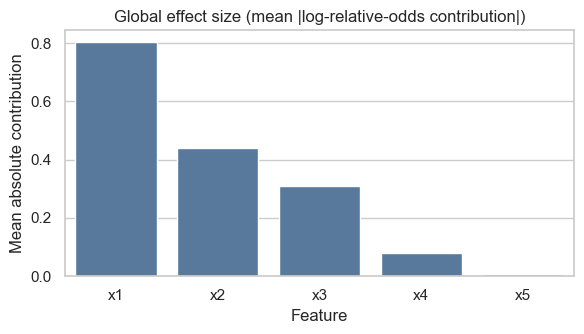

Sample 773: y=1.0 | p_hat=0.864
Top positive contributors:
  x1: +0.949
  x2: +0.843
  x3: +0.026
Top negative contributors:
  x4: -0.114
  x5: -0.008
  x3: +0.026


/var/folders/gy/xl1f5wqj7s5d372fjfdbh6q40000gn/T/ipykernel_84542/577582559.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)
/var/folders/gy/xl1f5wqj7s5d372fjfdbh6q40000gn/T/ipykernel_84542/577582559.py:35: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x=labels, y=values, palette=colors)


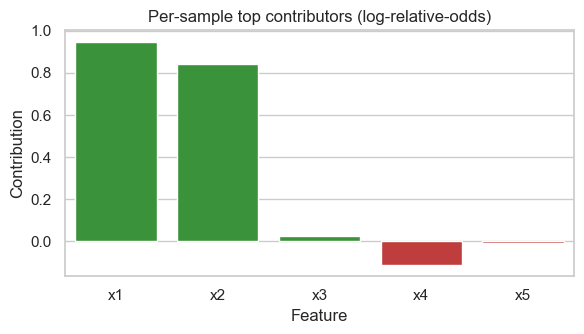

In [21]:
# Compute per-feature contributions across the dataset
contribs = {name: contribution_log_relative_odds(fm, df[name].values) for name, fm in [(fm.name, fm) for fm in feature_models]}
mean_abs = {name: float(np.mean(np.abs(vals))) for name, vals in contribs.items()}
ranked = sorted(mean_abs.items(), key=lambda kv: kv[1], reverse=True)

plt.figure(figsize=(6, 3.5))
sns.barplot(x=[k for k, _ in ranked], y=[v for _, v in ranked], color="#4C78A8")
plt.title("Global effect size (mean |log-relative-odds contribution|)")
plt.xlabel("Feature")
plt.ylabel("Mean absolute contribution")
plt.tight_layout()
plt.show()

# Explain a single sample
idx = int(np.random.randint(0, n))
row = df.iloc[idx]
row_contribs = {name: float(contribs[name][idx]) for name in feature_names}
sorted_parts = sorted(row_contribs.items(), key=lambda kv: kv[1], reverse=True)
top_pos = sorted_parts[:3]
top_neg = sorted(sorted_parts[-3:], key=lambda kv: kv[1])
print(f"Sample {idx}: y={row['y']} | p_hat={row['p_hat']:.3f}")
print("Top positive contributors:")
for k, v in top_pos:
    print(f"  {k}: {v:+.3f}")
print("Top negative contributors:")
for k, v in top_neg:
    print(f"  {k}: {v:+.3f}")

# Plot per-sample bar chart
parts_all = top_pos + top_neg
labels = [k for k, _ in parts_all]
values = [v for _, v in parts_all]
colors = ["#2ca02c" if v > 0 else "#d62728" for v in values]
plt.figure(figsize=(6, 3.5))
sns.barplot(x=labels, y=values, palette=colors)
plt.title("Per-sample top contributors (log-relative-odds)")
plt.xlabel("Feature")
plt.ylabel("Contribution")
plt.tight_layout()
plt.show()

## Conclusions, limitations, and next steps

- This naive Bayes-style explanation is fast and interpretable but assumes conditional independence of features.
- It can highlight plausible contributors even on noisy data, but do not conflate contribution with causality.
- Consider regularization, feature grouping, and calibration if using on real data.
- Next: extend to categorical features, interaction terms, and cross-validation for stability.

## Use on your data

Below is a minimal template to use the explainer on your own binary outcome dataset. Replace `X_user` and `y_user` with your data.

In [22]:
# Template: apply to your data
# X_user: pd.DataFrame of features (numeric or one-hot), y_user: array-like of 0/1
# explainer = NaiveLogOddsExplainer().fit(X_user, y_user)
# p_user = explainer.predict_proba(X_user)
# print("AUC:", roc_auc_score(y_user, p_user))
# example_idx = 0
# print(explainer.explain_row(X_user, example_idx, top_k=3))

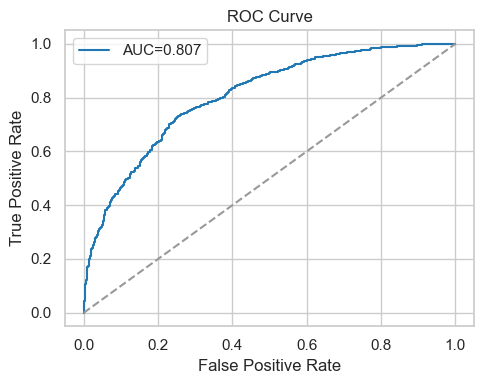

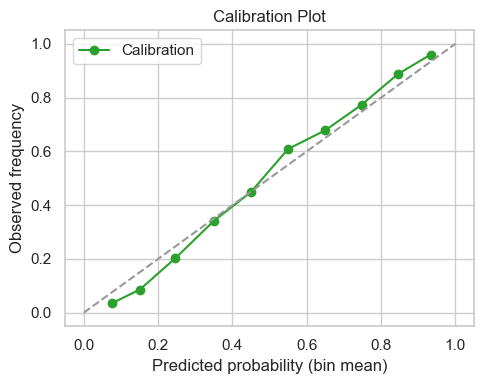

In [23]:
# Evaluation plots: ROC and calibration
from sklearn.metrics import roc_curve
from sklearn.calibration import calibration_curve

fpr, tpr, _ = roc_curve(df["y"], df["p_hat"])
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}", color="#1f77b4")
plt.plot([0,1],[0,1],"--", color="#999999")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

prob_true, prob_pred = calibration_curve(df["y"], df["p_hat"], n_bins=10, strategy="uniform")
plt.figure(figsize=(5, 4))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration", color="#2ca02c")
plt.plot([0,1],[0,1],"--", color="#999999")
plt.xlabel("Predicted probability (bin mean)")
plt.ylabel("Observed frequency")
plt.title("Calibration Plot")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Reusable Explainer class
class NaiveLogOddsExplainer:
    """Naive Bayes-style per-feature logistic explainer.

    Methods:
    - fit(X: pd.DataFrame, y: array_like) -> self
    - predict_proba(X) -> np.ndarray
    - explain_row(X, idx, top_k=3) -> dict of top positive/negative contributors
    """
    def __init__(self):
        self.feature_models: List[FeatureModel] = []
        self.feature_names: List[str] = []
        self.base_rate: Optional[float] = None

    def fit(self, X: pd.DataFrame, y: np.ndarray | pd.Series):
        self.feature_names = list(X.columns)
        self.feature_models = [
            fit_feature_model(X[name].values, np.asarray(y), name) for name in self.feature_names
        ]
        self.base_rate = float(np.mean(y))
        return self

    def predict_log_odds(self, X: pd.DataFrame) -> np.ndarray:
        return aggregate_log_odds(self.feature_models, X[self.feature_names])

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        if self.base_rate is None:
            raise RuntimeError("Model not fit: base_rate is None")
        lo = self.predict_log_odds(X)
        return score_to_prob(lo, base_rate=self.base_rate)

    def explain_row(self, X: pd.DataFrame, idx: int, top_k: int = 3):
        parts = {}
        for fm in self.feature_models:
            parts[fm.name] = float(contribution_log_relative_odds(fm, X.loc[idx, fm.name]))
        # sort and select
        sorted_items = sorted(parts.items(), key=lambda kv: kv[1], reverse=True)
        return {
            "top_positive": sorted_items[:top_k],
            "top_negative": sorted(sorted_items[-top_k:], key=lambda kv: kv[1]),
        }


explainer = NaiveLogOddsExplainer().fit(df[feature_names], df["y"])
p_hat2 = explainer.predict_proba(df[feature_names])
print(f"AUC (class)= {roc_auc_score(df['y'], p_hat2):.3f}")

AUC (class)= 0.807
